In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Load datasets
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
#sample_submission = pd.read_csv("sample_submission.csv")

# Display basic info
print("Train Data Info:")
print(train_data.info())
print("\nTest Data Info:")
print(test_data.info())

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84960 entries, 0 to 84959
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            84960 non-null  int64  
 1   Year                          84960 non-null  int64  
 2   Month                         84960 non-null  int64  
 3   Day                           84960 non-null  int64  
 4   kingdom                       84960 non-null  object 
 5   latitude                      84960 non-null  float64
 6   longitude                     84960 non-null  float64
 7   Avg_Temperature               84960 non-null  float64
 8   Avg_Feels_Like_Temperature    84960 non-null  float64
 9   Temperature_Range             84960 non-null  float64
 10  Feels_Like_Temperature_Range  84960 non-null  float64
 11  Radiation                     84960 non-null  float64
 12  Rain_Amount                   84960 non-nul

In [3]:
# 1. Identify the rows to delete
february_29_rows_index = train_data[(train_data['Month'] == 2) & (train_data['Day'] == 29)].index
print(len(february_29_rows_index))
# 2. Delete the rows using the index
train_data = train_data.drop(february_29_rows_index)

60


In [4]:
unique_kingdoms = train_data['kingdom'].nunique()
print(f"Number of unique kingdoms: {unique_kingdoms}")

Number of unique kingdoms: 30


In [5]:
train_data['Year'] = train_data['Year'] + 2000
test_data['Year'] = test_data['Year'] + 2000

train_data['Date'] = pd.to_datetime(train_data[['Year', 'Month', 'Day']].astype(str).agg(lambda x: '{}-{}-{}'.format(str(x[0]).zfill(4), str(x[1]).zfill(2), str(x[2]).zfill(2)), axis=1), format='%Y-%m-%d')
test_data['Date'] = pd.to_datetime(test_data[['Year', 'Month', 'Day']].astype(str).agg(lambda x: '{}-{}-{}'.format(str(x[0]).zfill(4), str(x[1]).zfill(2), str(x[2]).zfill(2)), axis=1), format='%Y-%m-%d')
# Set the Date column as the index
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)


<ipython-input-5-dd3e7e59b51f>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_data['Date'] = pd.to_datetime(train_data[['Year', 'Month', 'Day']].astype(str).agg(lambda x: '{}-{}-{}'.format(str(x[0]).zfill(4), str(x[1]).zfill(2), str(x[2]).zfill(2)), axis=1), format='%Y-%m-%d')
<ipython-input-5-dd3e7e59b51f>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data['Date'] = pd.to_datetime(test_data[['Year', 'Month', 'Day']].astype(str).agg(lambda x: '{}-{}-{}'.format(str(x[0]).zfill(4), str(x[1]).zfill(2), str(x[2]).zfill(2)), axis=1), format='%Y-%m-%d')


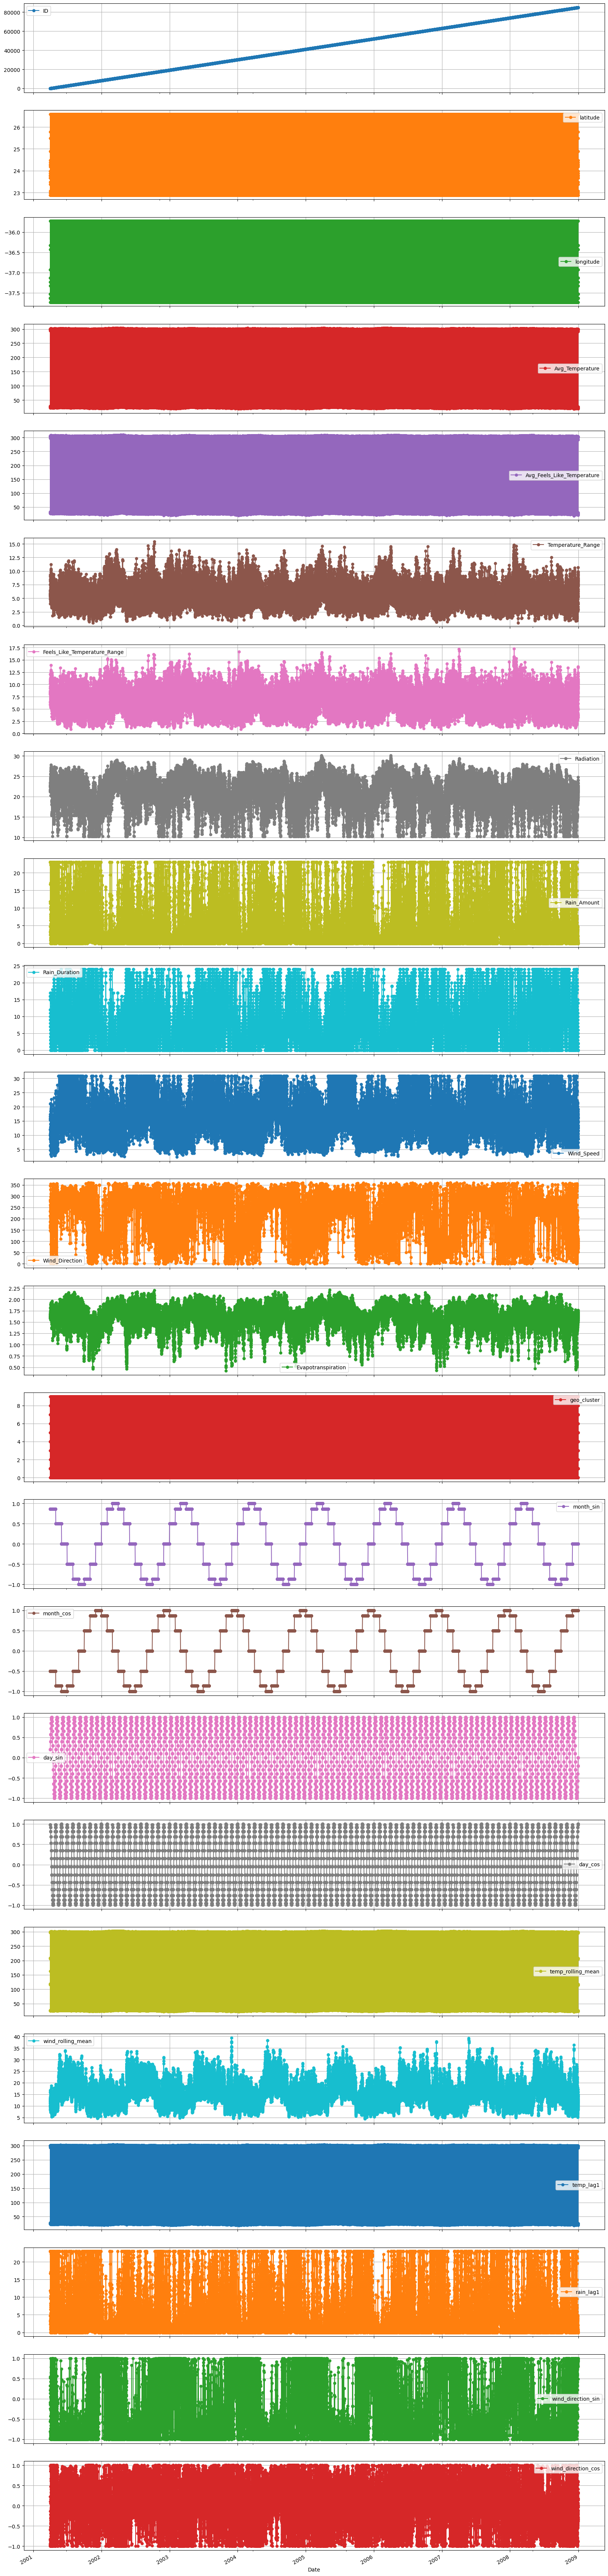

In [ ]:
train_data.plot(style='-o', markersize=5,figsize=(20,100),grid = True,subplots=True)
plt.show()

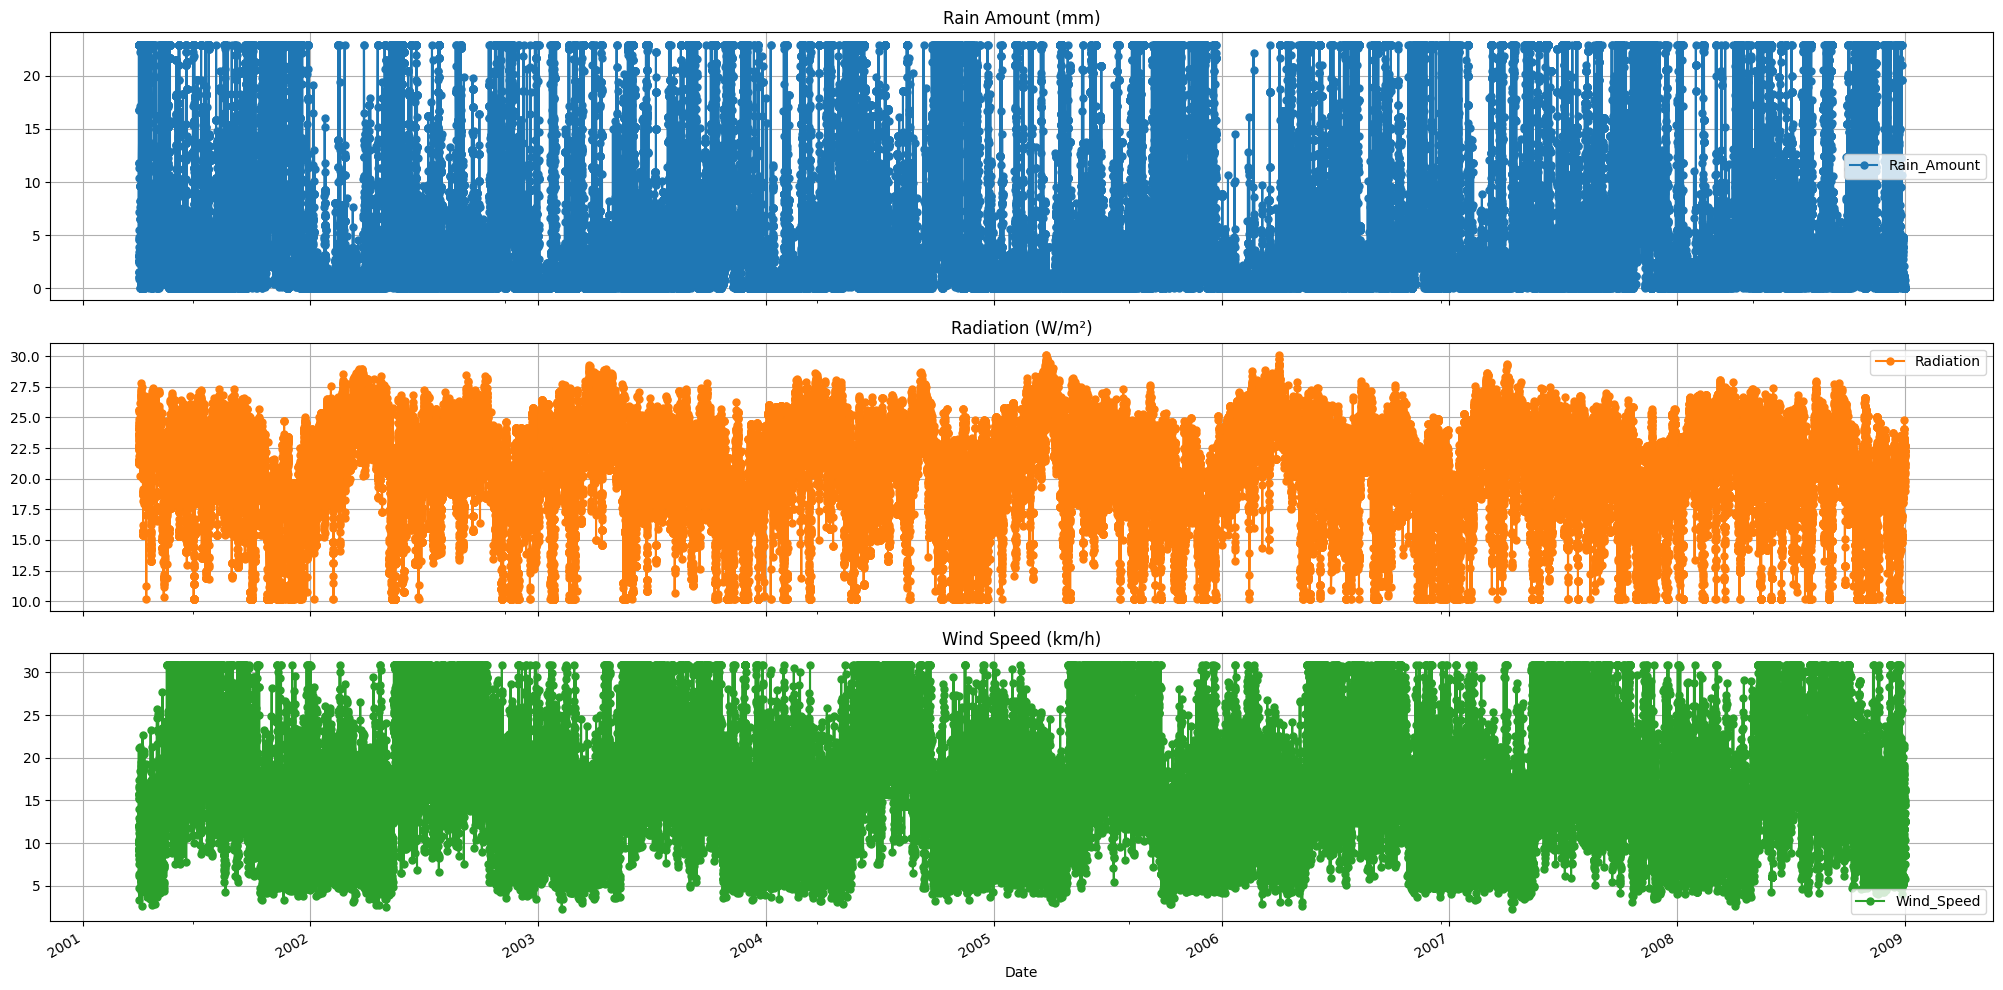

In [11]:
selected_columns = ['Rain_Amount', 'Radiation', 'Wind_Speed']
train_data[selected_columns].plot(
    style='-o',
    markersize=5,
    figsize=(20, 10),
    grid=True,
    subplots=True,
    title=['Rain Amount (mm)', 'Radiation (W/m²)', 'Wind Speed (km/h)']
)

plt.tight_layout()
plt.show()

In [7]:
from sklearn.cluster import KMeans

# Use KMeans to cluster locations into groups
kmeans = KMeans(n_clusters=10, random_state=42)
train_data['geo_cluster'] = kmeans.fit_predict(train_data[['latitude', 'longitude']])


In [8]:
Q1 = train_data['Rain_Amount'].quantile(0.25)
Q3 = train_data['Rain_Amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_data[(train_data['Rain_Amount'] < lower_bound) | (train_data['Rain_Amount'] > upper_bound)]
print(f"Number of outliers in Rain_Amount: {len(outliers)}")
train_data['Rain_Amount'] = train_data['Rain_Amount'].clip(lower_bound, upper_bound)

Number of outliers in Rain_Amount: 6564


In [9]:
Q1 = train_data['Wind_Speed'].quantile(0.25)
Q3 = train_data['Wind_Speed'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_data[(train_data['Wind_Speed'] < lower_bound) | (train_data['Wind_Speed'] > upper_bound)]
print(f"Number of outliers in Wind_Speed: {len(outliers)}")

train_data['Wind_Speed'] = train_data['Wind_Speed'].clip(lower_bound, upper_bound)


Number of outliers in Wind_Speed: 1989


In [10]:
Q1 = train_data['Radiation'].quantile(0.25)
Q3 = train_data['Radiation'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_data[(train_data['Radiation'] < lower_bound) | (train_data['Radiation'] > upper_bound)]
print(f"Number of outliers in Radiation: {len(outliers)}")

train_data['Radiation'] = train_data['Radiation'].clip(lower_bound, upper_bound)


Number of outliers in Radiation: 2031


In [12]:
# Encode month and day cyclically (since 12 months and 365 days are cyclic)
train_data['month_sin'] = np.sin(2 * np.pi * train_data['Month'] / 12)
train_data['month_cos'] = np.cos(2 * np.pi * train_data['Month'] / 12)

train_data['day_sin'] = np.sin(2 * np.pi * train_data['Day'] / 31)
train_data['day_cos'] = np.cos(2 * np.pi * train_data['Day'] / 31)


In [13]:
# Create rolling averages for temperature and wind speed
train_data['temp_rolling_mean'] = train_data['Avg_Temperature'].rolling(window=3, min_periods=1).mean()
train_data['wind_rolling_mean'] = train_data['Wind_Speed'].rolling(window=3, min_periods=1).mean()

# Lag Features (Previous day values)
train_data['temp_lag1'] = train_data['Avg_Temperature'].shift(1)
train_data['rain_lag1'] = train_data['Rain_Amount'].shift(1)


In [14]:
train_data['wind_direction_sin'] = np.sin(np.radians(train_data['Wind_Direction']))
train_data['wind_direction_cos'] = np.cos(np.radians(train_data['Wind_Direction']))

In [15]:
train_data.drop(columns=['kingdom', 'Year', 'Month', 'Day'], inplace=True)  # Drop original categorical and time-based columns

In [16]:
# Convert 'Month' and 'Day' to cyclic features
test_data['month_sin'] = np.sin(2 * np.pi * test_data['Month'] / 12)
test_data['month_cos'] = np.cos(2 * np.pi * test_data['Month'] / 12)

test_data['day_sin'] = np.sin(2 * np.pi * test_data['Day'] / 31)
test_data['day_cos'] = np.cos(2 * np.pi * test_data['Day'] / 31)

# Drop categorical column 'kingdom'
test_data.drop(columns=['kingdom'], inplace=True)

# Ensure test_data matches feature columns in train_data
test_data = test_data[['ID', 'Year', 'month_sin', 'month_cos', 'day_sin', 'day_cos']]


In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84900 entries, 2001-04-01 to 2008-12-31
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            84900 non-null  int64  
 1   latitude                      84900 non-null  float64
 2   longitude                     84900 non-null  float64
 3   Avg_Temperature               84900 non-null  float64
 4   Avg_Feels_Like_Temperature    84900 non-null  float64
 5   Temperature_Range             84900 non-null  float64
 6   Feels_Like_Temperature_Range  84900 non-null  float64
 7   Radiation                     84900 non-null  float64
 8   Rain_Amount                   84900 non-null  float64
 9   Rain_Duration                 84900 non-null  int64  
 10  Wind_Speed                    84900 non-null  float64
 11  Wind_Direction                84900 non-null  int64  
 12  Evapotranspiration            84900 non-nul

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define targets and seasonal features
targets = ['Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed', 'Wind_Direction']
seasonal_features = ['month_sin', 'month_cos', 'day_sin', 'day_cos']
all_features = targets + seasonal_features

# Prepare training data
train_series = train_data[all_features].values

# Create custom scaler - different scaling for targets vs seasonal features
preprocessor = ColumnTransformer(
    transformers=[
        ('targets', MinMaxScaler(), slice(0, 5)),  # MinMax for targets
        ('seasonal', StandardScaler(), slice(5, 9))  # Standard for seasonal
    ])

train_scaled = preprocessor.fit_transform(train_series)

# Create sequences for LSTM
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, :])  # All features (targets + seasonal)
        y.append(data[i, 0:5])  # Only target variables
    return np.array(X), np.array(y)

lookback = 90  # 3 months lookback window
X_train, y_train = create_sequences(train_scaled, lookback)

# Model architecture
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, len(all_features))),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(targets))  # Predict all 5 targets
])

model.compile(optimizer='adam', loss='mse')

# Training with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Forecasting function
def forecast_future(model, initial_sequence, test_seasonal, lookback):
    predictions = []
    current_sequence = initial_sequence.copy()

    for i in range(len(test_seasonal)):
        # Get prediction (1, lookback, n_features) -> (1, n_targets)
        pred = model.predict(current_sequence.reshape(1, lookback, len(all_features)), verbose=0)
        predictions.append(pred[0])

        # Create new row with:
        # - predicted targets (scaled)
        # - current seasonal features (from test data)
        new_row = np.concatenate([
            pred[0],  # predicted targets
            test_seasonal[i]  # seasonal features
        ])

        # Update sequence (remove oldest, add new)
        current_sequence = np.vstack([current_sequence[1:], new_row])

    return np.array(predictions)

# Prepare test data seasonal features
test_seasonal = test_data[seasonal_features].values

# Scale the test seasonal features using the same scaler
# We need to transform just the seasonal part (columns 5-9)
test_seasonal_scaled = preprocessor.named_transformers_['seasonal'].transform(test_seasonal)

# Get last 'lookback' days from training data as initial sequence
initial_sequence = train_scaled[-lookback:]

# Make predictions
test_predictions = forecast_future(model, initial_sequence, test_seasonal_scaled, lookback)

# Inverse transform the predictions (only need to inverse targets)
target_scaler = preprocessor.named_transformers_['targets']
test_predictions = target_scaler.inverse_transform(test_predictions)

# Create submission
submission = pd.DataFrame({
    'ID': test_data['ID'],
    'Avg_Temperature': test_predictions[:, 0],
    'Radiation': test_predictions[:, 1],
    'Rain_Amount': test_predictions[:, 2],
    'Wind_Speed': test_predictions[:, 3],
    'Wind_Direction': test_predictions[:, 4]
})

# Post-processing for realistic values
submission['Rain_Amount'] = submission['Rain_Amount'].clip(lower=0)
submission['Wind_Speed'] = submission['Wind_Speed'].clip(lower=0)
submission['Wind_Direction'] = submission['Wind_Direction'] % 360

# Save to CSV
submission.to_csv('submission_seasonal_lstm_final.csv', index=False)

print("Time series predictions with seasonal features saved to submission_seasonal_lstm.csv")
print(submission.head())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0743 - val_loss: 0.0472
Epoch 2/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0266 - val_loss: 0.0169
Epoch 3/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0217 - val_loss: 0.0171
Epoch 5/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0195 - val_loss: 0.0141
Epoch 6/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0146 - val_loss: 0.0137
Epoch 7/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0135 - val_loss: 0.0133
Epoch 8/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0128 - val_loss: 0.0148
Epoch 9/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0138 - val_loss: 0.0125
Epoch 10/10
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0123 - val_loss: 0.0128
Time series predictions with seasonal features saved to submission_seasonal_lstm.csv
              

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from google.colab import drive
from tensorflow.keras.losses import Huber

# Competition Evaluation Metric (sMAPE)
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0  # Handle zero denominators
    return 100 * np.mean(diff)

# Configuration
tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(True)

# Define targets and features
targets = ['Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed', 'Wind_Direction']
seasonal_feats = ['month_sin', 'month_cos', 'day_sin', 'day_cos']

# Define rolling windows
windows = {'Avg_Temperature': 7, 'Radiation': 3, 'Rain_Amount': 5,
           'Wind_Speed': 7, 'Wind_Direction': 5}

# Enhanced Data Preparation
def add_features(df):
    dates = pd.to_datetime(df.index if isinstance(df.index, pd.DatetimeIndex)
                          else df['date'] if 'date' in df.columns
                          else pd.to_datetime(df['ID'], format='%Y%m%d'))

    # Enhanced cyclical features
    df['month_sin'] = np.sin(2 * np.pi * (dates.month-1)/11)
    df['month_cos'] = np.cos(2 * np.pi * (dates.month-1)/11)
    df['day_sin'] = np.sin(2 * np.pi * (dates.day-1)/30)
    df['day_cos'] = np.cos(2 * np.pi * (dates.day-1)/30)

    # Rolling features with target-specific windows
    for target in targets:
        df[f'{target}_rolling{windows[target]}'] = df[target].rolling(windows[target], min_periods=1).mean()
        df[f'{target}_diff1'] = df[target].diff().fillna(0)

    return df

# Prepare data
train_data = add_features(train_data)
all_features = targets + seasonal_feats + \
               [f'{t}_rolling{windows[t]}' for t in targets] + \
               [f'{t}_diff1' for t in targets]

# Initialize scalers
target_scalers = {t: MinMaxScaler() for t in targets}
for t in targets:
    train_data[t] = target_scalers[t].fit_transform(train_data[[t]])

# Sequence Creation
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data.iloc[i-lookback:i][all_features].values)
        y.append(data.iloc[i][targets].values)
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data)

# Model Architecture
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(128),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(len(targets))
])

# Training Configuration
optimizer = Adam(learning_rate=0.001, clipvalue=0.5)
model.compile(optimizer=optimizer,  loss=Huber())

# Validation Split
val_size = int(0.2 * len(X_train))
X_val, y_val = X_train[-val_size:], y_train[-val_size:]
X_train, y_train = X_train[:-val_size], y_train[:-val_size]

# Training with Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

# Competition Evaluation
def evaluate_smape(model, X, y, scalers):
    y_pred = model.predict(X, verbose=0)

    # Inverse transform
    y_true = np.zeros_like(y)
    y_pred_inv = np.zeros_like(y_pred)
    for i, t in enumerate(targets):
        y_true[:, i] = scalers[t].inverse_transform(y[:, i].reshape(-1, 1)).flatten()
        y_pred_inv[:, i] = scalers[t].inverse_transform(y_pred[:, i].reshape(-1, 1)).flatten()

    # Calculate sMAPE for each target
    smapes = {}
    for i, t in enumerate(targets):
        smapes[t] = smape(y_true[:, i], y_pred_inv[:, i])

    # Calculate final score (average sMAPE)
    final_score = np.mean(list(smapes.values()))

    print("\n=== Validation sMAPE Scores ===")
    for t, score in smapes.items():
        print(f"{t}: {score:.2f}%")
    print(f"\nFinal Competition Score: {final_score:.2f}%")

    return smapes, final_score

# Evaluate before submission
val_smapes, val_score = evaluate_smape(model, X_val, y_val, target_scalers)

# Generate Test Predictions
def predict_test(model, initial_sequence, test_data, lookback):
    predictions = []
    current_seq = initial_sequence.copy()

    test_dates = pd.to_datetime(test_data.index if isinstance(test_data.index, pd.DatetimeIndex)
                              else test_data['date'] if 'date' in test_data.columns
                              else pd.to_datetime(test_data['ID'], format='%Y%m%d'))

    test_seasonal = np.column_stack([
        np.sin(2 * np.pi * (test_dates.month-1)/11),
        np.cos(2 * np.pi * (test_dates.month-1)/11),
        np.sin(2 * np.pi * (test_dates.day-1)/30),
        np.cos(2 * np.pi * (test_dates.day-1)/30)
    ])

    for i in range(len(test_data)):
        pred = model.predict(current_seq[np.newaxis], verbose=0)[0]
        predictions.append(pred)

        new_row = np.zeros(len(all_features))
        new_row[:len(targets)] = pred
        new_row[len(targets):len(targets)+4] = test_seasonal[i]
        new_row[len(targets)+4:] = current_seq[-1, len(targets)+4:]

        current_seq = np.vstack([current_seq[1:], new_row])

    return np.array(predictions)

# Generate and save predictions
last_sequence = train_data.iloc[-60:][all_features].values
test_predictions = predict_test(model, last_sequence, test_data, 60)

# Prepare submission
submission = pd.DataFrame({'ID': test_data['ID']})
for i, t in enumerate(targets):
    submission[t] = target_scalers[t].inverse_transform(test_predictions[:, i].reshape(-1, 1)).flatten()

# Post-processing
submission['Rain_Amount'] = submission['Rain_Amount'].clip(lower=0)
submission['Wind_Speed'] = submission['Wind_Speed'].clip(lower=0)
submission['Wind_Direction'] = submission['Wind_Direction'] % 360

# Save to Drive

submission.to_csv('submission_seasonal_lstm_65.csv', index=False)


# Show validation metrics again
print(f"\nValidation sMAPE: {val_score:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0758 - val_loss: 0.0137 - learning_rate: 0.0010
Epoch 2/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.0137 - val_loss: 0.0094 - learning_rate: 0.0010
Epoch 3/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0102 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 4/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0084 - val_loss: 0.0071 - learning_rate: 0.0010
Epoch 5/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0073 - val_loss: 0.0073 - learning_rate: 0.0010
Epoch 6/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0067 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 7/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0061 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 8/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0056 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 9/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0053 - val_loss: 0.0055 - learning_rate: 0.00